In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import sys
import hardware_control.wx_programs as wx
import hardware_control.bnc as bnc
from classes.generator import *
from hardware_control.hardware_config import *
from experiment_configuration.values import *
from classes.qubit_class import *
import daq.daq_programs_homo as daq
import seaborn as sns
import analysis.plotting as plotting
import analysis.analysis as analysis
import standard_sequences.pinopi as pnp


In [2]:
wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"
C1_address="GPIB0::6::INSTR"
C2_address="GPIB0::10::INSTR"
bnc.set_bnc_output(
    general_vals_dict["qubit_bnc"], power_dBm=13, bnc_addr=target_bnc_address_6
)
bnc.set_bnc_output(
    readout_dict["RO_LO"],
    power_dBm=readout_dict["RO_LO_pwr"],
    bnc_addr=bnc_address["target_bnc_black"],
)
bnc.set_bnc_output(
    general_vals_dict["TWPA_freq"],
    general_vals_dict["TWPA_amp"],
    bnc_addr= bnc_address["TWPA_address"],
)

In [3]:
q1 = Qubit(q1_dict, readout_dict)
q2 = Qubit(q2_dict, readout_dict)
readout = Readout(readout_dict)
print(f"{q1}\n{q2}")

Qubit(RO_IF=None, RO_LO_pwr=16, ro_dur=5000, ge_amp=1, ro_freq=6.72736, qubit_id=q1, ROIF=0.1026600000000002, mixer_offset_ef=6, ro_amp=0.2, ef_ssm=-0.259, ge_time=77, ef_half_time=25, RO_LO=6.6247, IQ_angle=60, ef_half_amp=1.3, ef_amp=1.5, ef_time=46, RO_LO_34=6.4804, qubit_thr=[-10000, -600], ge_ssm=-0.117, mixer_offset_ge=2.5, RO_LO_45=6.3804)
Qubit(RO_IF=None, RO_LO_pwr=16, ro_dur=5000, ge_amp=1, ro_freq=6.6554, qubit_id=q2, ROIF=0.030700000000000394, mixer_offset_ef=None, ro_amp=0.6, ef_ssm=-0.2962, ge_time=62, ef_half_time=None, RO_LO=6.6247, IQ_angle=25, ef_half_amp=None, ef_amp=1, ef_time=None, RO_LO_34=6.4804, qubit_thr=[-10000, 1900], ge_ssm=-0.155, mixer_offset_ge=2.5, RO_LO_45=6.3804)


In [4]:
def make_hist(IQdata, ax_hist,labelstr):
    binwidth = 200
    lim_IQ_min = np.min([IQdata])
    lim_IQ_max = np.max([IQdata])
    
    bins_IQ = np.arange(lim_IQ_min, lim_IQ_max, binwidth)
    
    counts_IQ = ax_hist.hist(IQdata, bins=bins_IQ, histtype='step', orientation='vertical', label = labelstr)[0]
    
    gauss_xaxis = np.linspace(lim_IQ_min,lim_IQ_max, len(counts_IQ))
    
    
    return bins_IQ,counts_IQ, gauss_xaxis


def plot_hist_and_fit(data_g, data_e, label_g, label_e, axis_label):
    ax = plt.axes()
    print(f"{axis_label} histogram")
    bins_g, counts_g, gauss_x_g = make_hist(data_g, ax, label_g)
    bins_e, counts_e, gauss_x_e = make_hist(data_e, ax, label_e)
    _, mu_g, std_g = analysis.fit_gaussian_no_plot(data_g, gauss_x_g, counts_g, ax)
    _, mu_e, std_e = analysis.fit_gaussian_no_plot(data_e, gauss_x_e, counts_e, ax)
    ax.legend()
    plt.show()
    return mu_g, std_g, mu_e, std_e



In [5]:
def run_pi_no_pi(q1, q2, general_vals_dict,num_steps, reps):
    # pnp.pi_nopi_ge(0, 0, q2, q1, general_vals_dict)
    # pnp.pi_nopi_ge(1, 1, q2, q1, general_vals_dict)

    pnp.pi_nopi_ef(0, 0, 0, q1, q2, general_vals_dict)
    pnp.pi_nopi_ef(1, 1, 1, q1, q2, general_vals_dict)
    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=True
    )
    return values

def get_snr(q1, q2, general_vals_dict,num_steps, reps):
    values= run_pi_no_pi(q1, q2, general_vals_dict,num_steps, reps) 
    mu_Ig, std_Ig, mu_Ie, std_Ie = plot_hist_and_fit(
        values.rec_readout_vs_pats_1[0, :, 0],  # Ig
        values.rec_readout_vs_pats_1[0, :, 1],  # Ie
        'Ig', 'Ie', 'I'
    )

    # Plot and fit Q quadrature
    mu_Qg, std_Qg, mu_Qe, std_Qe = plot_hist_and_fit(
        values.rec_readout_vs_pats_1[1, :, 0],  # Qg
        values.rec_readout_vs_pats_1[1, :, 1],  # Qe
        'Qg', 'Qe', 'Q'
    )

    # Calculate SNR
    signal = np.sqrt((mu_Ig - mu_Ie) ** 2 + (mu_Qg - mu_Qe) ** 2)
    noise = np.mean([np.abs(std_Ig), np.abs(std_Qg), np.abs(std_Ie), np.abs(std_Qe)])
    SNR = signal / noise

    print("SNR:", SNR)
    return SNR

In [6]:
def sweep_ro_freq(sweep_list):
    num_steps=3
    reps=5000
    SNR_list = []
    for freq in sweep_list:
        q1.ROIF = freq-readout_dict["RO_LO"]
        SNR = get_snr(q1, q2, general_vals_dict,num_steps, reps)
        SNR_list.append(SNR)
    return SNR_list

def sweep_ro_amp(sweep_list):
    num_steps=3
    reps=5000
    SNR_list = []
    for amp in sweep_list:
        q1.ro_amp = amp
        SNR = get_snr(q1, q2, general_vals_dict,num_steps, reps)
        SNR_list.append(SNR)
    return SNR_list

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 3
Records per pattern: 5000
Buffers per acquistion: 5
DAQ samples per pattern: 8192
0, No error
Capturing 5 buffers. Press <enter> to abort
Capture completed in 3.811188 sec
Captured 5 buffers (1.311927 buffers per sec)
Captured 15360 records (4030.2

<Figure size 800x800 with 0 Axes>

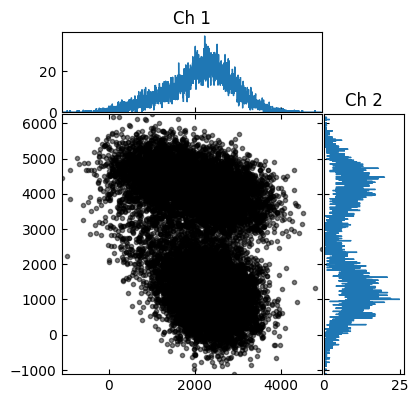

<Figure size 800x800 with 0 Axes>

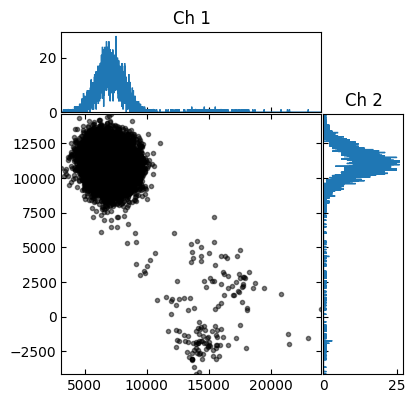

I histogram


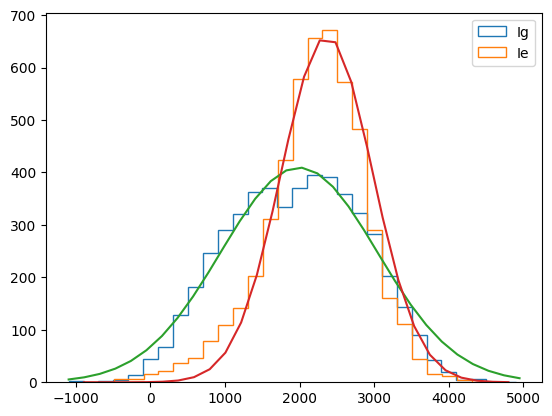

Q histogram


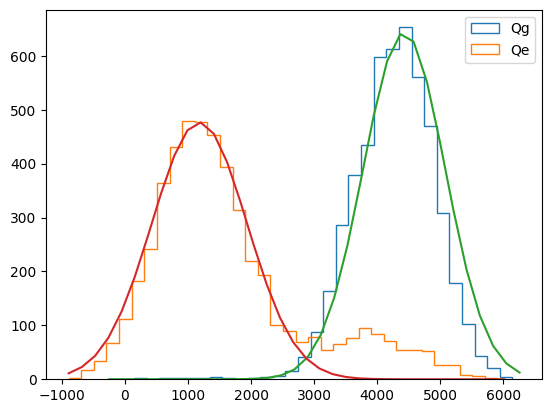

SNR: 4.257021149806158
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 3
Records per pattern: 5000
Buffers per acquistion: 5
DAQ samples per pattern: 8192
0, No error
Capturing 5 buffers. Press <enter> to abort
Capture completed in 3.753147 sec
Captured 5 buffers (1.332215 buffers per sec)
Capture

<Figure size 800x800 with 0 Axes>

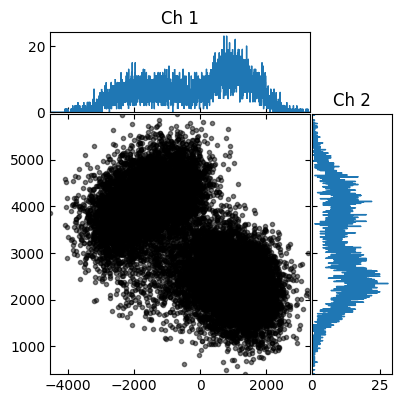

<Figure size 800x800 with 0 Axes>

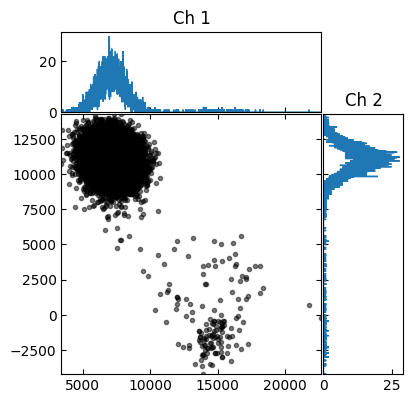

I histogram


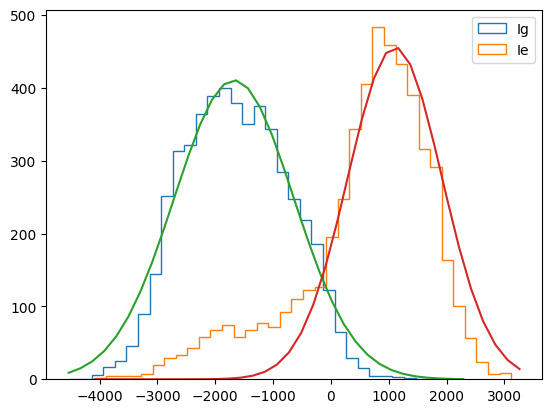

Q histogram


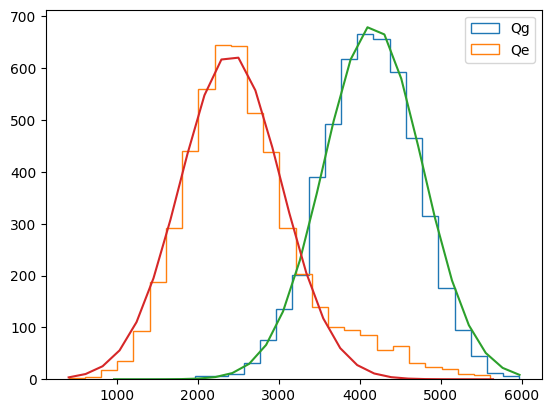

SNR: 4.267212249140719
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4


In [ ]:
freq_start = 6.7271
freq_stop = 6.7275
freq_steps=21
freq_list = np.linspace(freq_start, freq_stop, freq_steps)
SNR_list = sweep_ro_freq(freq_list)

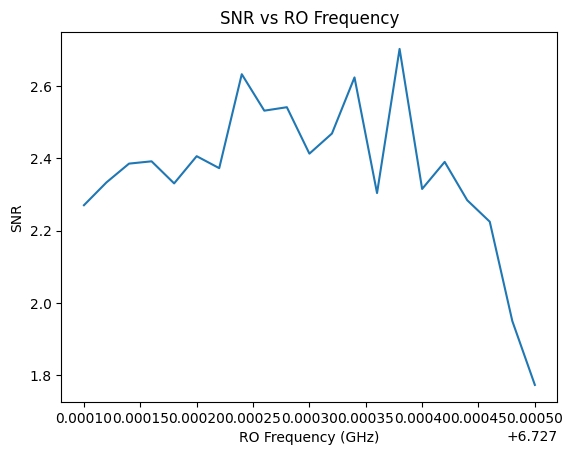

In [ ]:
plt.plot(freq_list, SNR_list)
plt.xlabel("RO Frequency (GHz)")
plt.ylabel("SNR")
plt.title("SNR vs RO Frequency")
plt.show()